In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from fastai.callbacks import *

In [4]:
PATH = Path('/content/data')

In [5]:
np.random.seed(42)

In [6]:
sz = 128
bs = 64

In [7]:
src = (ImageList.from_csv(PATH,'train.csv',folder='train',suffix='.jpg')
        .split_by_rand_pct(0.2,42)
         .label_from_df()
       )

In [8]:
xtra_tfms = zoom_crop(scale=(0.75,2), do_rand=True)
tfms = get_transforms(flip_vert=True,max_lighting=0.5,xtra_tfms=xtra_tfms)

In [9]:
def getdata(sz,bs):
    return src.transform(tfms,size=sz).databunch(bs=bs).normalize(imagenet_stats)

In [10]:
data = getdata(sz,bs)

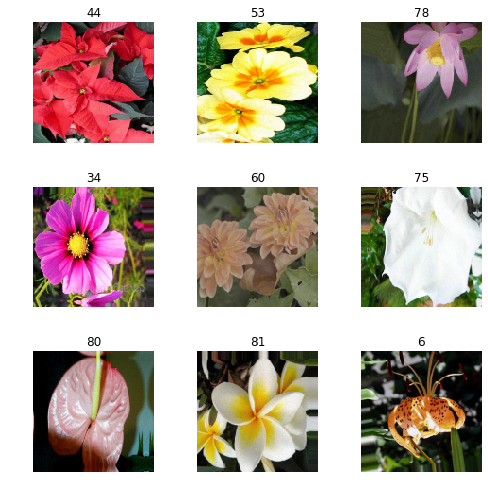

In [46]:
data.show_batch(rows=3,figsize=(7,7))

In [11]:
learn = cnn_learner(data,models.resnet34,metrics=[accuracy,error_rate],callback_fns=[CSVLogger],pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 25808374.67it/s]


In [12]:
learn.model_dir = '/content/gdrive/My Drive/GardeNerd/models'

In [13]:
learn.callbacks = [SaveModelCallback(learn,every='epoch',monitor='accuracy',name='model')]

In [55]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.050830,0.985957,0.757821,0.242179,02:51
1,0.929573,0.469526,0.865156,0.134844,02:54
2,0.625427,0.322521,0.911543,0.088457,02:55
3,0.534484,0.298621,0.919094,0.080906,02:53


In [61]:
learn.save('Renet34_stage-1')

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 9.12E-04


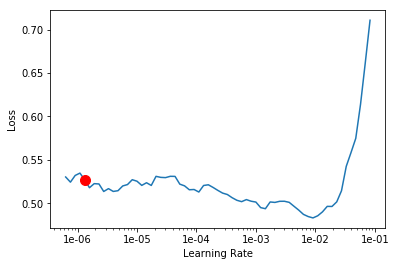

In [59]:
learn.recorder.plot(suggestion=True)

In [62]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.467615,0.213077,0.941478,0.058522,02:55


In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


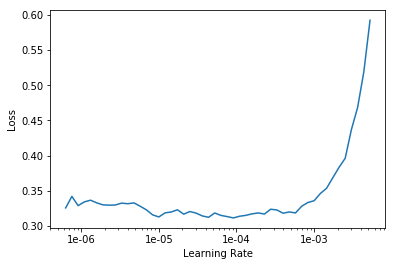

In [65]:
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(30,max_lr=slice(8e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.340573,0.210386,0.941478,0.058522,02:54
1,0.340811,0.215157,0.936893,0.063107,02:52
2,0.333219,0.205132,0.942557,0.057443,02:51
3,0.329898,0.200529,0.943096,0.056904,02:52
4,0.320619,0.195593,0.946332,0.053668,02:58
5,0.310673,0.185069,0.949569,0.050432,03:04
6,0.307136,0.176265,0.951726,0.048274,05:42
7,0.282017,0.173375,0.951996,0.048004,05:06
8,0.296300,0.166500,0.956580,0.043420,03:10
9,0.270840,0.159048,0.958738,0.041262,03:08


In [68]:
learn.save('resnet34_stage-2')

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


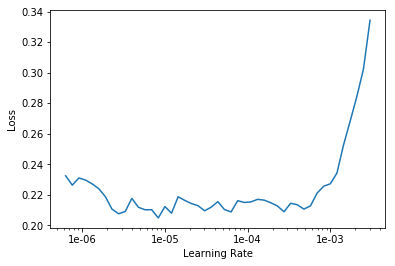

In [70]:
learn.recorder.plot()

In [72]:
learn.load('model_2');

In [73]:
sz = 224
learn.data = getdata(sz,bs)

In [77]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0,0.388133,0.096265,0.972492,0.027508,04:20
1,1,0.293379,0.073384,0.977616,0.022384,04:19
2,2,0.239856,0.061566,0.981931,0.018069,04:17
3,3,0.232428,0.075785,0.975189,0.024811,04:17
4,4,0.244481,0.106558,0.967368,0.032632,04:17
5,5,0.259803,0.147520,0.951187,0.048813,04:17
6,6,0.303347,0.178264,0.949569,0.050432,04:17
7,7,0.353690,0.174822,0.943366,0.056634,04:18


In [85]:
learn.load('model_1');

In [86]:
learn.save('resnet34_stage-4')

In [15]:
learn.load('resnet34_stage-4');

In [16]:
sz = 500
learn.data = getdata(sz,bs)

In [17]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


In [84]:
learn.fit_one_cycle(40)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.408799,0.086963,0.976807,0.023193,08:27
1,0.285762,0.072283,0.982470,0.017530,08:28
2,0.237726,0.067598,0.980852,0.019148,08:30
3,0.238130,0.075800,0.980043,0.019957,08:33
4,0.251955,0.078033,0.976807,0.023193,08:37


KeyboardInterrupt: 

# Submission

In [87]:
sample_df = pd.read_csv(PATH/'sample_submission.csv')
learn.data.add_test(ImageList.from_df(sample_df,PATH,folder='test',suffix='.jpg'))

#preds,y = learn.get_preds(ds_type=DatasetType.Test)
preds,y = learn.TTA(ds_type=DatasetType.Test)
sample_df.category = preds.argmax(1) + 1
sample_df.to_csv('submission.csv',index=False)

In [91]:
learn.data.train_ds.x[0].shape

torch.Size([3, 500, 500])